In [ ]:
import numpy as np
import random
import os
import pickle
import tarfile
import urllib.request
from keras.datasets import mnist
from keras.models import load_model
from keras.models import Sequential, Model, save_model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Add, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.models import Model

The following function is just to normalize the images , scales image pixel values to a range of 0 to 1, to prepare data for training the model

In [ ]:
def normalize_img_lab(images, labels):
    images = images.numpy() if not isinstance(images, np.ndarray) else images
    labels = labels.numpy() if not isinstance(labels, np.ndarray) else labels
    images = images.astype('float32') / 255.0
    images = images.reshape((images.shape[0], 28, 28, 1))
    return images, labels

This network is a hybrid model that integrates an autoencoder for image denoising and a classifier for handwritten digit recognition. Initially, it encodes input images, removes noise, and subsequently reconstructs the cleaned images. Then, the encoded data undergoes a sequence of convolutional layers equipped with batch normalization, dropout, and fully connected layers to facilitate the classification of handwritten digits into ten distinct categories.

In [ ]:
input_image = Input(shape=(28, 28, 1))

# Encoder
encoder = Conv2D(32, (3, 3), activation='relu', padding='same')(input_image)
encoder = MaxPooling2D((2, 2))(encoder)
residual = encoder
encoder = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)
encoder = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder)
encoded = MaxPooling2D((2, 2), padding='same')(encoder)

# Decoder
decoder = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(32, (3, 3), activation='relu', padding='same')(decoder)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(32, (3, 3), activation='relu')(decoder)
decoder = Add()([decoder, residual])
decoder = UpSampling2D((2, 2))(decoder)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoder)

# Classifier
classifier = Conv2D(32, (3, 3), padding='same', activation='relu')(decoded)
classifier = BatchNormalization()(classifier)
classifier = Conv2D(32, (3, 3), padding='same', activation='relu')(classifier)
classifier = BatchNormalization()(classifier)
classifier = Conv2D(32, (5, 5), strides=2, padding='same', activation='relu')(classifier)
classifier = BatchNormalization()(classifier)
classifier = Dropout(0.4)(classifier)
classifier = Conv2D(64, (3, 3), padding='same', activation='relu')(classifier)
classifier = BatchNormalization()(classifier)
classifier = Conv2D(64, (3, 3), padding='same', activation='relu')(classifier)
classifier = BatchNormalization()(classifier)
classifier = Conv2D(64, (5, 5), strides=2, padding='same', activation='relu')(classifier)
classifier = BatchNormalization()(classifier)
classifier = Dropout(0.4)(classifier)
classifier = Flatten()(classifier)
classifier = Dense(128, activation='relu')(classifier)
classifier = BatchNormalization()(classifier)
classifier = Dropout(0.4)(classifier)
output = Dense(10, activation='softmax')(classifier)

model = Model(inputs=input_image, outputs=output)


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

The function prepares a dataset by adding slight noise to images, scales the images to values between 0 and 1, and then trains a given model on this noisy dataset using early stopping and model checkpoint callbacks. It helps create a robust model against noise.

In [ ]:
def get_original_trained_model_on_slight_noise(model, epochs):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    noise_factor = 310
    x_train_n = x_train + np.random.normal(loc=0.0, scale=noise_factor, size=x_train.shape)
    x_test_n = x_test + np.random.normal(loc=0.0, scale=noise_factor, size=x_test.shape)
    x_train_n = np.clip(x_train_n, 0., 255.)
    x_test_n = np.clip(x_test_n, 0., 255.)
    x_train_n = x_train_n.astype('float32') / 255.
    x_test_n = x_test_n.astype('float32') / 255.
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.

    early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')
    checkpoint = tf.keras.callbacks.ModelCheckpoint('autoencoder_model.h5', save_best_only=True, monitor='val_loss', mode='min')
    model.fit(x_train_n, y_train, epochs=epochs, batch_size=128, shuffle=True,
              validation_data=(x_test_n, y_test), callbacks=[early_stop, checkpoint])


After training a model to eliminate image noise,I subsequently load this trained model. New noisy image data is prepared, normalized, and split for training and testing purposes. To ensure effective training, early stopping and model checkpointing are employed, safeguarding against overfitting and keeping the best model. This prepares the model for further training on the new noisy data while maintaining performance control.

In [ ]:
get_original_trained_model_on_slight_noise(model, 100)
model=load_model('autoencoder_model.h5')

Epoch 1/100
469/469 [==============================] - 32s 29ms/step - loss: 1.3573 - accuracy: 0.5571 - val_loss: 1.3610 - val_accuracy: 0.5312
Epoch 2/100
  1/469 [..............................] - ETA: 13s - loss: 1.0508 - accuracy: 0.6719

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


469/469 [==============================] - 12s 26ms/step - loss: 0.9628 - accuracy: 0.6757 - val_loss: 0.8845 - val_accuracy: 0.7056
Epoch 3/100
469/469 [==============================] - 13s 27ms/step - loss: 0.9095 - accuracy: 0.6943 - val_loss: 0.8597 - val_accuracy: 0.7137
Epoch 4/100
469/469 [==============================] - 12s 26ms/step - loss: 0.8756 - accuracy: 0.7047 - val_loss: 0.8429 - val_accuracy: 0.7214
Epoch 5/100
469/469 [==============================] - 12s 26ms/step - loss: 0.8493 - accuracy: 0.7149 - val_loss: 0.7859 - val_accuracy: 0.7392
Epoch 6/100
469/469 [==============================] - 13s 27ms/step - loss: 0.8222 - accuracy: 0.7208 - val_loss: 0.8704 - val_accuracy: 0.7101
Epoch 7/100
469/469 [==============================] - 13s 27ms/step - loss: 0.8095 - accuracy: 0.7258 - val_loss: 0.7898 - val_accuracy: 0.7371
Epoch 8/100
469/469 [==============================] - 12s 26ms/step - loss: 0.7929 - accuracy: 0.7316 - val_loss: 0.7844 - val_accuracy: 0.73

In [ ]:
n_images = pickle.load(open(os.path.join("636_project1_train_images"), 'rb'))
n_labels = pickle.load(open(os.path.join("636_project1_train_labels"), 'rb'))
n_images, n_labels = normalize_img_lab(n_images, n_labels)
n_dataset = list(zip(n_images, n_labels))
random.shuffle(n_dataset)
n_images, n_labels = zip(*n_dataset)
n_images, n_labels = np.array(list(n_images)), np.array(list(n_labels))
n_train_images = n_images[:51234]
n_test_images = n_images[51234:]
n_train_labels = n_labels[:51234]
n_test_labels = n_labels[51234:]


Epoch 1/100
321/321 [==============================] - 18s 34ms/step - loss: 1.2529 - accuracy: 0.5851 - val_loss: 1.3235 - val_accuracy: 0.5582
Epoch 2/100
321/321 [==============================] - 9s 27ms/step - loss: 1.0546 - accuracy: 0.6426 - val_loss: 3.3916 - val_accuracy: 0.1114
Epoch 3/100
321/321 [==============================] - 9s 27ms/step - loss: 1.0245 - accuracy: 0.6523 - val_loss: 38.4194 - val_accuracy: 0.1032
Epoch 4/100
321/321 [==============================] - 8s 26ms/step - loss: 0.9902 - accuracy: 0.6618 - val_loss: 73.2624 - val_accuracy: 0.1007
Epoch 5/100
321/321 [==============================] - 9s 27ms/step - loss: 0.9661 - accuracy: 0.6722 - val_loss: 21.5674 - val_accuracy: 0.1301
Epoch 6/100
321/321 [==============================] - 8s 26ms/step - loss: 0.9523 - accuracy: 0.6743 - val_loss: 13.4612 - val_accuracy: 0.1215
Epoch 7/100
321/321 [==============================] - 8s 26ms/step - loss: 0.9296 - accuracy: 0.6815 - val_loss: 2.6578 - val_accu

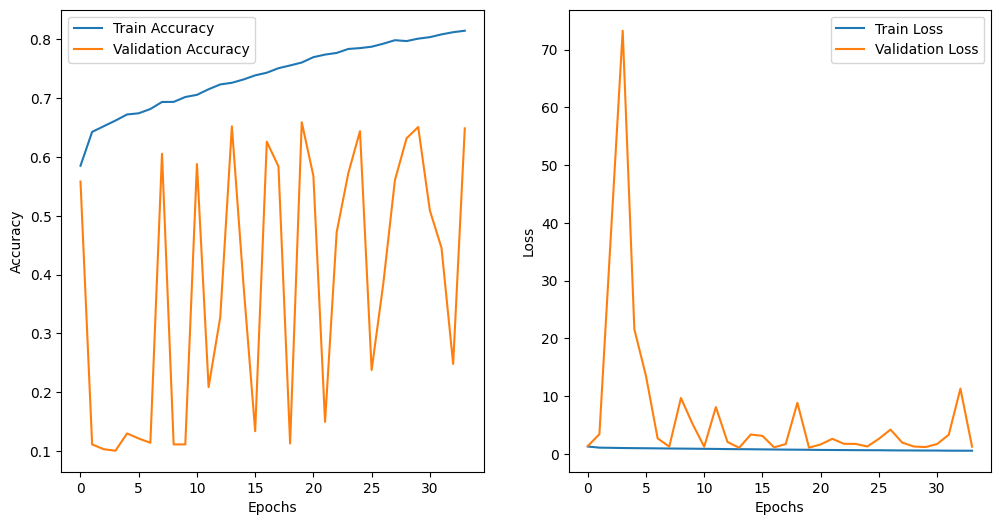

274/274 [==============================] - 2s 5ms/step - loss: 1.2092 - accuracy: 0.6637
Test accuracy: 0.664


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min')
checkpoint = ModelCheckpoint('autoencoder_model.h5', save_best_only=True, monitor='val_loss', mode='min')
history = model.fit(n_train_images, n_train_labels, epochs=100, batch_size=128, shuffle=True, validation_split=0.2, callbacks=[early_stop, checkpoint])
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
test_loss, test_acc = model.evaluate(n_test_images, n_test_labels)
print(f"Test accuracy: {test_acc:.3f}")


In [ ]:
model = load_model('autoencoder_model.h5')
test_loss, test_acc = model.evaluate(n_test_images, n_test_labels)
print(f"Test accuracy: {test_acc:.3f}")

274/274 [==============================] - 2s 6ms/step - loss: 1.0414 - accuracy: 0.6548
Test accuracy: 0.655


In [ ]:
from tensorflow.keras import models
import pickle
import tensorflow as tf

model = models.load_model("./autoencoder_model.h5")
test_labels = pickle.load(open("./636_project1_test_labels", 'rb'))
test_images = pickle.load(open("./636_project1_test_images", 'rb'))


# Include your data preprocessing code if applicable
# <your data preprocessing code>
# Include your data preprocessing code if applicable


test_loss, test_acc = model.evaluate(test_images, test_labels)
your_score = round(test_acc*1000) / 10
print(f"Your Score: {your_score}")